In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt

In [2]:

class CNN_default(nn.Module):
    def __init__(self, optimizer_type, learning_rate):
        super(CNN_default, self).__init__()
        self.optimizer_type = optimizer_type
        self.learning_rate = learning_rate
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return x
    
    def fit(self, train_loader, epochs):
        optimizer = self.optimizer_type(self.parameters(), lr=self.learning_rate)
        self.train()
        
        for images, labels in train_loader:
            # Прямой проход
            outputs = self(images)
            loss = self.loss_function(outputs, labels)
            
            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()
        
    def evaluate(self, test_loader):
        correct = 0
        total = 0

        total_loss = 0
        
        self.eval()
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = self(images)
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                loss = self.loss_function(outputs, labels)
                total_loss += loss.item()
        
        return correct / total, total_loss / len(test_loader)

In [3]:

class LeNet(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(LeNet, self).__init__(optimizer, learning_rate)
        
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

MNIST_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
MNIST_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

MNIST_train_loader = DataLoader(MNIST_train_dataset, batch_size=32, shuffle=True)
MNIST_test_loader = DataLoader(MNIST_test_dataset, batch_size=32, shuffle=False)

print(f"Размер обучающего датасета: {len(MNIST_train_dataset)}")
print(f"Размер тестового датасета: {len(MNIST_test_dataset)}")

Размер обучающего датасета: 60000
Размер тестового датасета: 10000


In [5]:
LeNet_SGD_accuracies = []
LeNet_SGD_losses = []

LeNet_SGD_model = LeNet(optim.SGD, learning_rate=1e-6)
for _ in range(10):
    LeNet_SGD_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_SGD_model.evaluate(MNIST_test_loader)
    LeNet_SGD_accuracies.append(accurace)
    LeNet_SGD_losses.append(losses)
    print(accurace, losses)

0.1135 2.300181971571316
0.1135 2.291385365751224
0.2316 2.2503571853089257
0.5601 1.4648415444377132
0.8293 1.0609404945600267
0.8424 0.606728948985997
0.8826 0.43743333618599956
0.9 0.3315431561630469
0.9245 0.2563145027641719
0.9346 0.23429810516714764


In [6]:
LeNet_AdaDelta_accuracies = []
LeNet_AdaDelta_losses = []

LeNet_AdaDelta_model = LeNet(optim.Adadelta, learning_rate=1e-6)
for _ in range(10):
    LeNet_AdaDelta_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_AdaDelta_model.evaluate(MNIST_test_loader)
    LeNet_AdaDelta_accuracies.append(accurace)
    LeNet_AdaDelta_losses.append(losses)
    print(accurace, losses)

0.1028 2.3011313589236226
0.1028 2.300977156185114
0.1028 2.300839181906118
0.1028 2.30070647111716
0.1028 2.300576651819979
0.1028 2.3004484824098337
0.1028 2.3003214494869733
0.1028 2.300195292542918
0.1028 2.30006957968203
0.1028 2.299944402310795


In [7]:
LeNet_NAG_accuracies = []
LeNet_NAG_losses = []

LeNet_NAG_model = LeNet(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-6)
for _ in range(10):
    LeNet_NAG_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_NAG_model.evaluate(MNIST_test_loader)
    LeNet_NAG_accuracies.append(accurace)
    LeNet_NAG_losses.append(losses)
    print(accurace, losses)

0.4573 1.953259871409724
0.7406 0.9212526997057394
0.8424 0.6103668164271421
0.8166 0.7717378270297576
0.8225 0.6948459938156624
0.8164 0.8738306589876882
0.7844 1.3638990293450344
0.6434 1.515319217651035
0.3702 1.8373372985151248
0.0958 3.036217283517027


In [8]:
LeNet_Adam_accuracies = []
LeNet_Adam_losses = []

LeNet_Adam_model = LeNet(optim.Adam, learning_rate=1e-6)
for _ in range(10):
    LeNet_Adam_model.fit(MNIST_train_loader, epochs=1)
    accurace, losses = LeNet_Adam_model.evaluate(MNIST_test_loader)
    LeNet_Adam_accuracies.append(accurace)
    LeNet_Adam_losses.append(losses)
    print(accurace, losses)

0.1533 2.261191993475722
0.374 2.182014958165324
0.4581 2.0525784861927217
0.5243 1.8706747015444234
0.6046 1.6423621314783066
0.6684 1.3908065534628238
0.7294 1.1468194239436629
0.7604 0.9390021713016132
0.7767 0.7812328390039194
0.7923 0.6753225699305153


In [9]:
epoch_list = list(range(10))

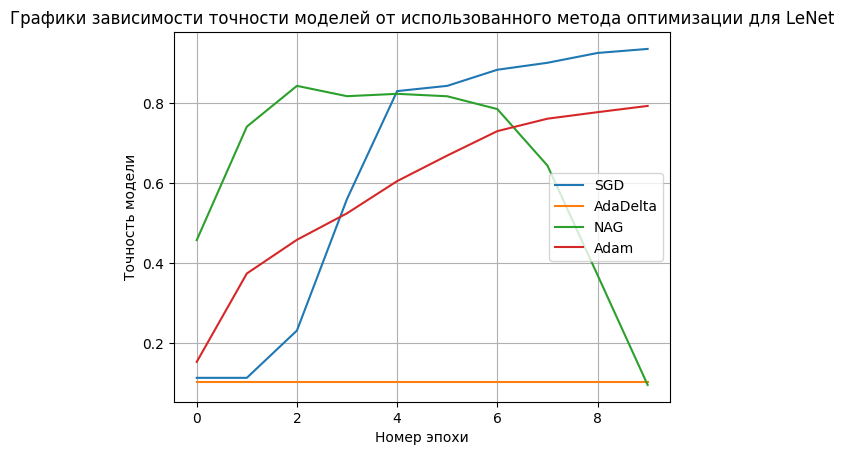

In [10]:
plt.plot(epoch_list, LeNet_SGD_accuracies, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_accuracies, label="NAG")
plt.plot(epoch_list, LeNet_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()

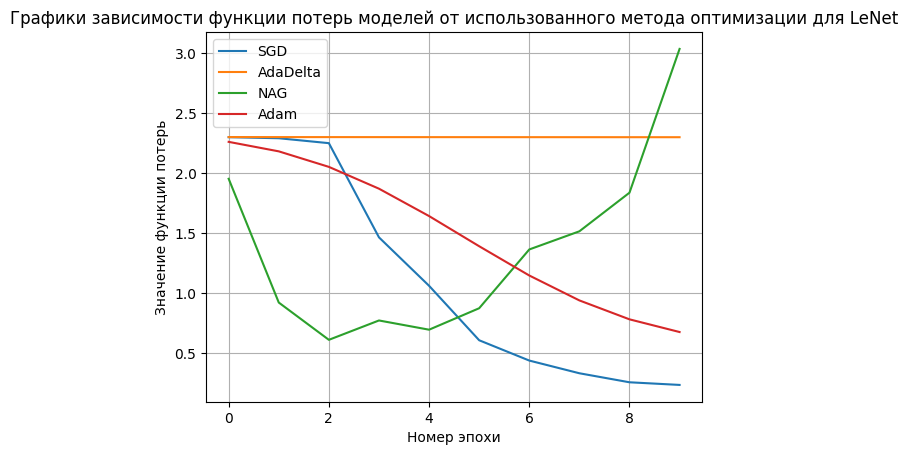

In [11]:
plt.plot(epoch_list, LeNet_SGD_losses, label="SGD")
plt.plot(epoch_list, LeNet_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, LeNet_NAG_losses, label="NAG")
plt.plot(epoch_list, LeNet_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для LeNet")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
class VGG16(CNN_default):
    def __init__(self, optimizer, learning_rate):
        super(VGG16, self).__init__(optimizer, learning_rate)
        
        self.conv1_1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.conv3_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool2(x)
        
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [16]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

CIFAR10_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
CIFAR10_test_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test)

CIFAR10_train_loader = DataLoader(CIFAR10_train_dataset, batch_size=32, num_workers=6, shuffle=True)
CIFAR10_test_loader = DataLoader(CIFAR10_test_dataset, batch_size=32, num_workers=6, shuffle=False)

print(f"Размер обучающего набора: {len(CIFAR10_train_dataset)}")
print(f"Размер тестового набора: {len(CIFAR10_test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Размер обучающего набора: 50000
Размер тестового набора: 50000


In [18]:
VGG16_SGD_accuracies = []
VGG16_SGD_losses = []

VGG16_SGD_model = VGG16(optim.SGD, learning_rate=1e-4)
for _ in range(10):
    VGG16_SGD_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_SGD_model.evaluate(CIFAR10_test_loader)
    VGG16_SGD_accuracies.append(accurace)
    VGG16_SGD_losses.append(losses)
    print(accurace, losses)

In [ ]:
VGG16_AdaDelta_accuracies = []
VGG16_AdaDelta_losses = []

VGG16_AdaDelta_model = VGG16(optim.Adadelta, learning_rate=1e-4)
for _ in range(10):
    VGG16_AdaDelta_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_AdaDelta_model.evaluate(CIFAR10_test_loader)
    VGG16_AdaDelta_accuracies.append(accurace)
    VGG16_AdaDelta_losses.append(losses)
    print(accurace, losses)

0.1 2.3026172521399597
0.1 2.3024878436300287
0.1 2.3023390989614767
0.1 2.3021776133138863
0.1 2.302003050643667
0.1 2.3018124164561775
0.1 2.3016018656988746
0.1 2.3013671936320708


KeyboardInterrupt: 

In [ ]:
VGG16_NAG_accuracies = []
VGG16_NAG_losses = []

VGG16_NAG_model = VGG16(lambda params, lr: optim.SGD(params, lr=lr, momentum=.9, nesterov=True), learning_rate=1e-4)
for _ in range(10):
    VGG16_NAG_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_NAG_model.evaluate(CIFAR10_test_loader)
    VGG16_NAG_accuracies.append(accurace)
    VGG16_NAG_losses.append(losses)
    print(accurace, losses)

In [ ]:
VGG16_Adam_accuracies = []
VGG16_Adam_losses = []

VGG16_Adam_model = VGG16(optim.Adam, learning_rate=1e-4)
for _ in range(10):
    VGG16_Adam_model.fit(CIFAR10_train_loader, epochs=1)
    accurace, losses = VGG16_Adam_model.evaluate(CIFAR10_test_loader)
    VGG16_Adam_accuracies.append(accurace)
    VGG16_Adam_losses.append(losses)
    print(accurace, losses)

In [ ]:
plt.plot(epoch_list, VGG16_SGD_accuracies, label="SGD")
plt.plot(epoch_list, VGG16_AdaDelta_accuracies, label="AdaDelta")
plt.plot(epoch_list, VGG16_NAG_accuracies, label="NAG")
plt.plot(epoch_list, VGG16_Adam_accuracies, label="Adam")

plt.title("Графики зависимости точности моделей от использованного метода оптимизации для VGG16")
plt.xlabel("Номер эпохи")
plt.ylabel("Точность модели")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
plt.plot(epoch_list, VGG16_SGD_losses, label="SGD")
plt.plot(epoch_list, VGG16_AdaDelta_losses, label="AdaDelta")
plt.plot(epoch_list, VGG16_NAG_losses, label="NAG")
plt.plot(epoch_list, VGG16_Adam_losses, label="Adam")

plt.title("Графики зависимости функции потерь моделей от использованного метода оптимизации для VGG16")
plt.xlabel("Номер эпохи")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
class BasicBlock(CNN_default):
    expansion = 1

    def __init__(self, optimizer, learning_rate):
        super(BasicBlock, self).__init__(optimizer, learning_rate)
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet34(CNN_default):
    def __init__(self, optimizer, learning_rate, num_classes=1000):
        super(ResNet34, self).__init__(optimizer, learning_rate)
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(64, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 4, stride=2)
        self.layer3 = self._make_layer(128, 256, 6, stride=2)
        self.layer4 = self._make_layer(256, 512, 3, stride=2)
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(BasicBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x